In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from traj_utils import *
import matplotlib.pyplot as plt
from viz_utils import *

/home/beans/bespoke/constants.py:435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SIM_RUN_ID = "sim"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [26]:
aux, targets, run_paths = [], [], []
n_couldnt_load_runs = 0

for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            print(run_path)
            n_couldnt_load_runs += 1
            continue
            
        _aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        _targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        aux.append(_aux)
        targets.append(_targets)
        run_paths.append(run_path)
        
aux = na(np.stack(aux, axis=0), AUX_PROPS)
targets = np.stack(targets, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

/home/beans/blender_membank/dataloader_00/run_52
/home/beans/blender_membank/dataloader_01/run_52
/home/beans/blender_membank/dataloader_02/run_52
/home/beans/blender_membank/dataloader_03/run_53
/home/beans/blender_membank/dataloader_04/run_54
/home/beans/blender_membank/dataloader_05/run_54
/home/beans/blender_membank/dataloader_06/run_52
/home/beans/blender_membank/dataloader_07/run_54
/home/beans/blender_membank/dataloader_08/run_54
/home/beans/blender_membank/dataloader_09/run_53
/home/beans/blender_membank/dataloader_10/run_55
/home/beans/blender_membank/dataloader_11/run_52
couldn't load 12 out of 1536 runs


In [27]:
all_wp_angles, all_wp_dists, all_wp_rolls, all_wp_zs = np.split(targets, 4, axis=-1)

In [28]:
%%time
speed_mask = get_speed_mask(aux[:,:,'speed'])
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)
all_curvatures = get_curvatures_from_headings_batch(all_headings)

CPU times: user 51.4 s, sys: 299 ms, total: 51.7 s
Wall time: 54.6 s


In [29]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape, speed_mask.shape

((1524, 1280, 30),
 (1524, 1280, 30),
 (1524, 1280, 30),
 (1524, 1280, 30),
 (1524, 1280, 30))

In [30]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .1:
        print(i, m)
        mm += 1

491 0.11720556


In [31]:
run_paths[2]

'/home/beans/blender_membank/dataloader_00/run_2'

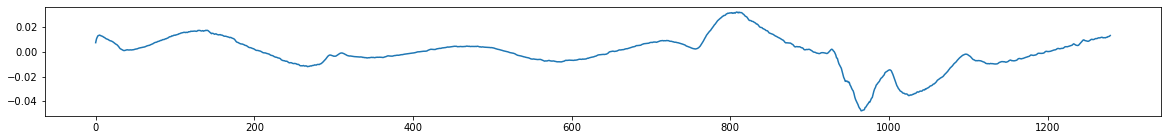

In [32]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[2,:,0])

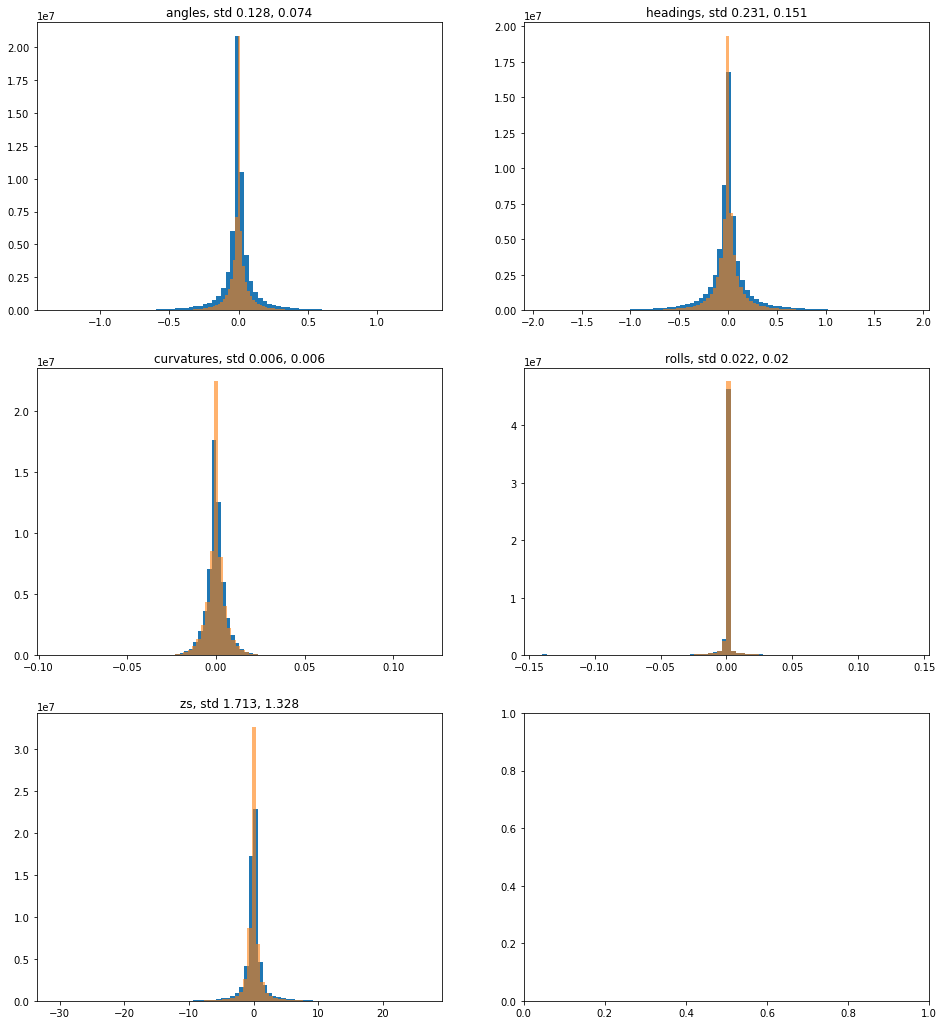

In [33]:
ws = [all_wp_angles, all_headings, all_curvatures, all_wp_rolls, all_wp_zs]
plot_wps(ws, speed_mask)

In [34]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.0265472 , 0.03079768, 0.03488598, 0.03897166, 0.04305155,
       0.04712347, 0.0511848 , 0.05523348, 0.05926811, 0.06328654,
       0.06728819, 0.07127291, 0.07524003, 0.07918799, 0.08311621,
       0.08702368, 0.09091036, 0.09477625, 0.098621  , 0.10236814,
       0.13864362, 0.17320886, 0.20509648, 0.2340801 , 0.2603265 ,
       0.28411752, 0.30569726, 0.32523566, 0.34294015, 0.35190833],
      dtype=float32)

In [35]:
mean_headings[-1] / mean_headings[0]

13.255949

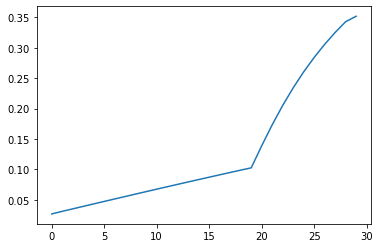

In [36]:
plt.plot(mean_headings)

In [37]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.0106336 , 0.01309385, 0.01550968, 0.01786324, 0.02016072,
       0.02241233, 0.02462679, 0.02681076, 0.02896919, 0.03110594,
       0.03322379, 0.03532477, 0.03741032, 0.03948166, 0.04153985,
       0.04358546, 0.04561926, 0.0476417 , 0.04965326, 0.05165433,
       0.07111316, 0.08960883, 0.10712956, 0.12362958, 0.13907662,
       0.15349022, 0.16692825, 0.17945032, 0.19112158, 0.201991  ],
      dtype=float32)

In [38]:
mean_angles[-1] / mean_angles[0]

18.99555

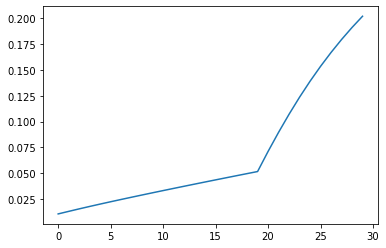

In [39]:
plt.plot(mean_angles)

In [40]:
all_wp_angles[:,:,0].std()

0.019055367

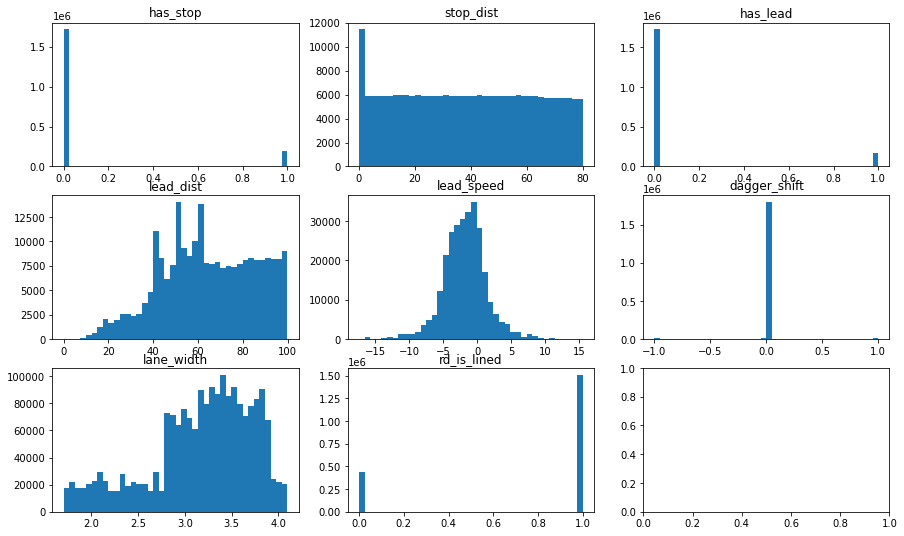

In [41]:
plot_aux(aux, AUX_TARGET_PROPS)

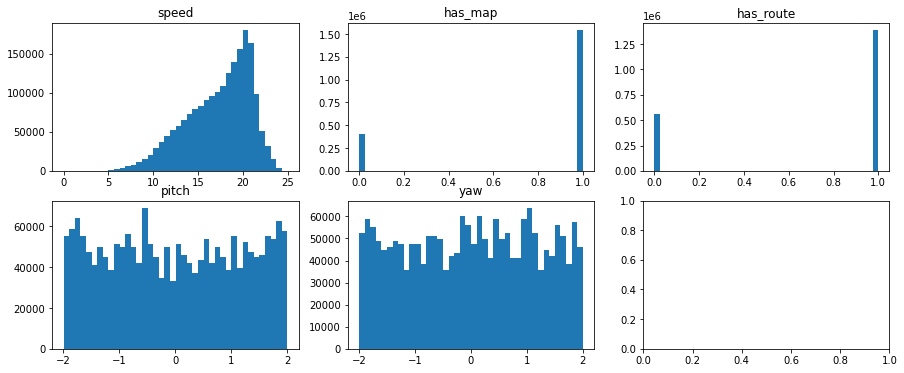

In [42]:
plot_aux(aux, AUX_MODEL_PROPS)

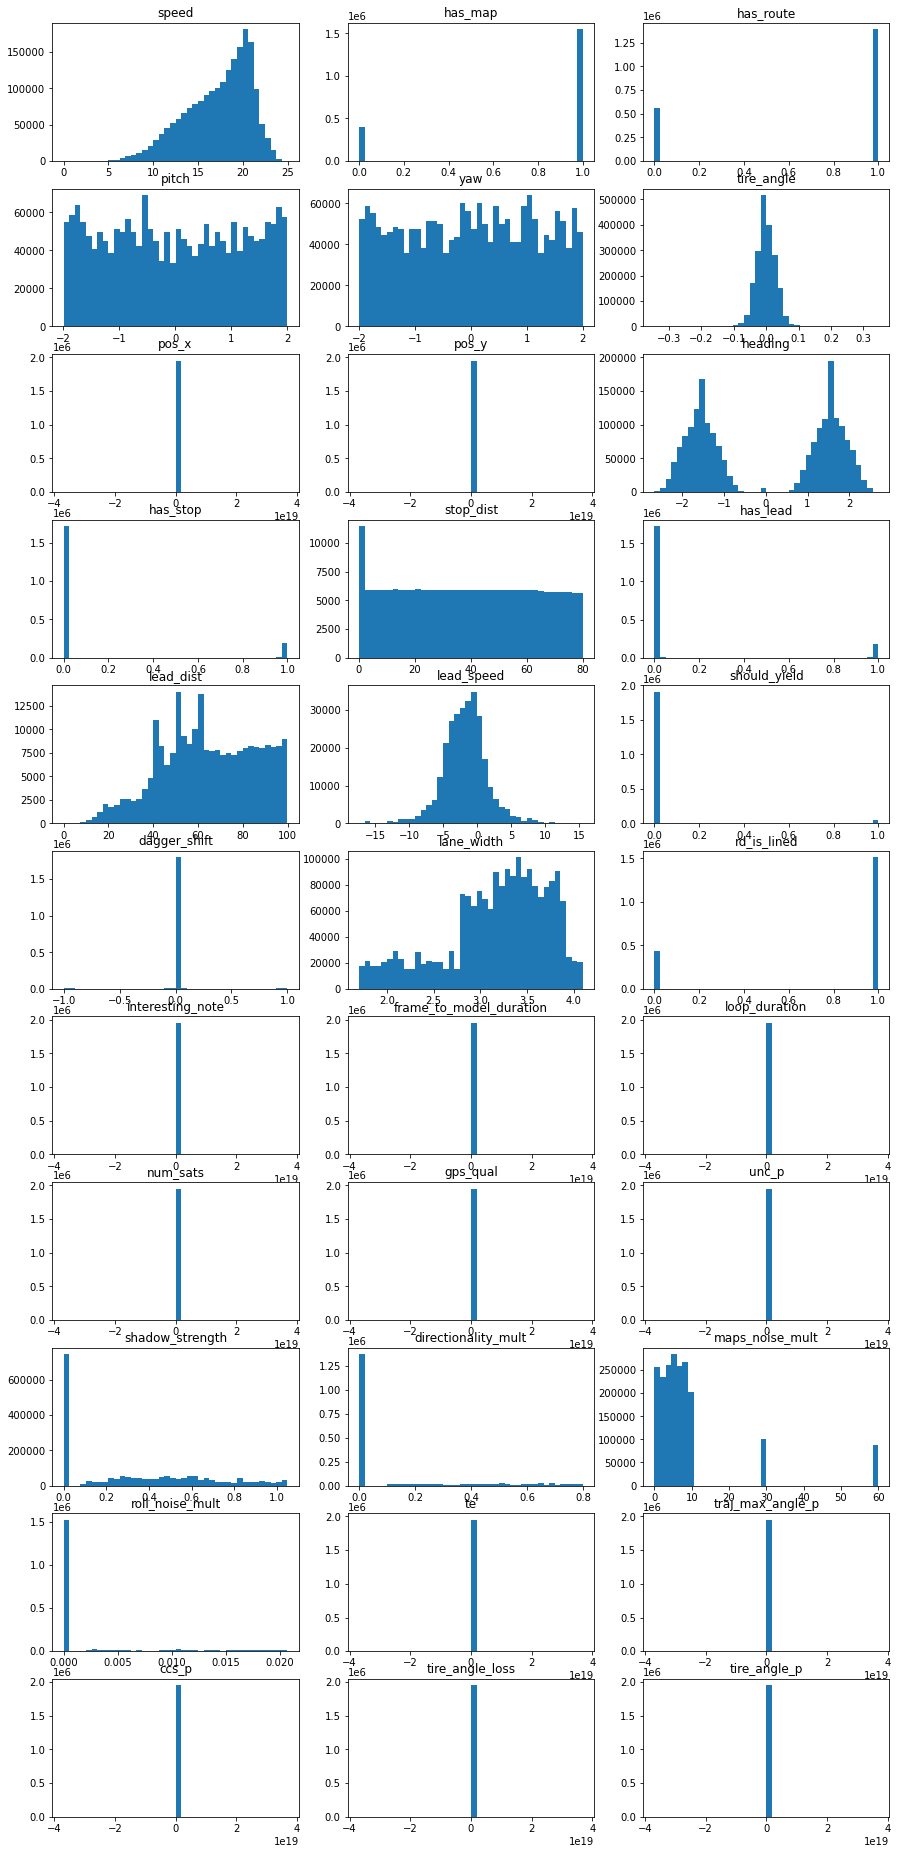

In [43]:
plot_aux(aux, AUX_PROPS)

In [44]:
np.quantile(abs(aux[:,:,"tire_angle"]), .999) #TODO this was .137, check again

0.1474039639830582